In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d ckay16/accident-detection-from-cctv-footage

Dataset URL: https://www.kaggle.com/datasets/ckay16/accident-detection-from-cctv-footage
License(s): ODbL-1.0
100% 249M/249M [00:02<00:00, 122MB/s]
100% 249M/249M [00:02<00:00, 113MB/s]


In [3]:
!unzip /content/accident-detection-from-cctv-footage.zip

Archive:  /content/accident-detection-from-cctv-footage.zip
  inflating: data/test/Accident/acc1 (7).jpg  
  inflating: data/test/Accident/test10_33.jpg  
  inflating: data/test/Accident/test10_56.jpg  
  inflating: data/test/Accident/test10_61.jpg  
  inflating: data/test/Accident/test12_13.jpg  
  inflating: data/test/Accident/test12_16.jpg  
  inflating: data/test/Accident/test13_22.jpg  
  inflating: data/test/Accident/test15_15.jpg  
  inflating: data/test/Accident/test18_22.jpg  
  inflating: data/test/Accident/test18_24.jpg  
  inflating: data/test/Accident/test19_26.jpg  
  inflating: data/test/Accident/test1_18.jpg  
  inflating: data/test/Accident/test1_20.jpg  
  inflating: data/test/Accident/test1_24.jpg  
  inflating: data/test/Accident/test1_26.jpg  
  inflating: data/test/Accident/test1_27.jpg  
  inflating: data/test/Accident/test21_10.jpg  
  inflating: data/test/Accident/test21_14.jpg  
  inflating: data/test/Accident/test21_18.jpg  
  inflating: data/test/Accident/te

In [4]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from time import perf_counter
import os
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.utils import plot_model

In [5]:
## Defining batch specfications
batch_size = 50
img_height = 224
img_width = 224

In [6]:
## loading training set
training_data = tf.keras.preprocessing.image_dataset_from_directory(
    'data/train',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 791 files belonging to 2 classes.


In [7]:
## loading validation dataset
validation_data =  tf.keras.preprocessing.image_dataset_from_directory(
    'data/val',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 98 files belonging to 2 classes.


In [8]:
## loading testing dataset
testing_data = tf.keras.preprocessing.image_dataset_from_directory(
    'data/test',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 100 files belonging to 2 classes.


In [9]:
testing_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
class_names = training_data.class_names
class_names

['Accident', 'Non Accident']

In [11]:
## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_data = training_data.cache().prefetch(buffer_size=AUTOTUNE)
testing_data = testing_data.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
img_shape = (img_height, img_width, 3)

base_model = tf.keras.applications.DenseNet121(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

29084464/29084464 [==============================] - 0s 0us/step


In [13]:
## Defining Cnn
model = tf.keras.Sequential([
    base_model,
    # layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    # layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation= 'softmax')
])


model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'], steps_per_execution=1)

In [14]:
model.build((None, 224, 224, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          294944    
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 128)         73856     
                                                                 
 global_average_pooling2d (  (None, 128)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                        

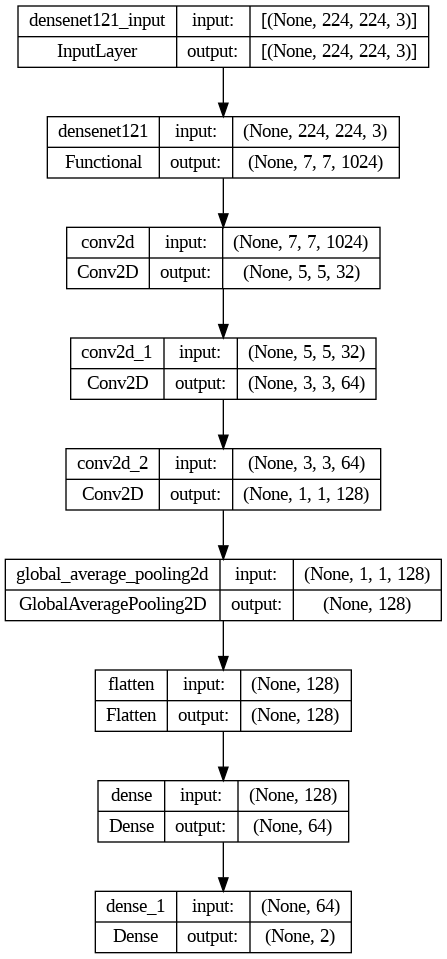

In [16]:
plot_model(model, show_shapes=True)

In [17]:
## lets train our CNN
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(training_data, validation_data=validation_data, epochs = 35, callbacks=callbacks_list)

Epoch 1/35
16/16 [==============================] - ETA: 0s - loss: 0.9972 - accuracy: 0.5424
Epoch 1: val_accuracy improved from -inf to 0.60204, saving model to model_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 36s 1s/step - loss: 0.9972 - accuracy: 0.5424 - val_loss: 0.6252 - val_accuracy: 0.6020
Epoch 2/35
16/16 [==============================] - ETA: 0s - loss: 0.5905 - accuracy: 0.6802
Epoch 2: val_accuracy improved from 0.60204 to 0.75510, saving model to model_weights.h5
16/16 [==============================] - 4s 255ms/step - loss: 0.5905 - accuracy: 0.6802 - val_loss: 0.5134 - val_accuracy: 0.7551
Epoch 3/35
16/16 [==============================] - ETA: 0s - loss: 0.5108 - accuracy: 0.7421
Epoch 3: val_accuracy improved from 0.75510 to 0.78571, saving model to model_weights.h5
16/16 [==============================] - 3s 215ms/step - loss: 0.5108 - accuracy: 0.7421 - val_loss: 0.4507 - val_accuracy: 0.7857
Epoch 4/35
16/16 [==============================] - ETA: 0s - loss: 0.4515 - accuracy: 0.7724
Epoch 4: val_accuracy improved from 0.78571 to 0.84694, saving model to model_weights.h5
16/16 [==============================] - 4s 226ms/step - los

In [18]:
model.save('model.h5')

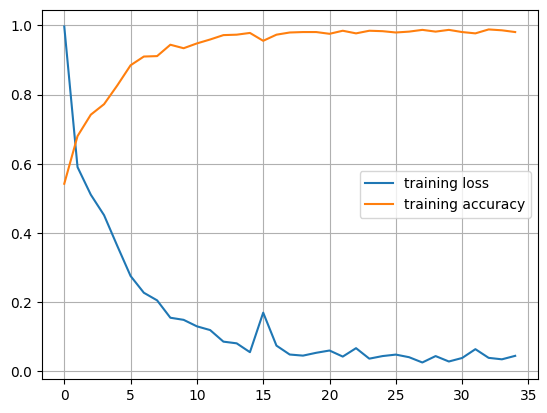

In [19]:
## stats on training data
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

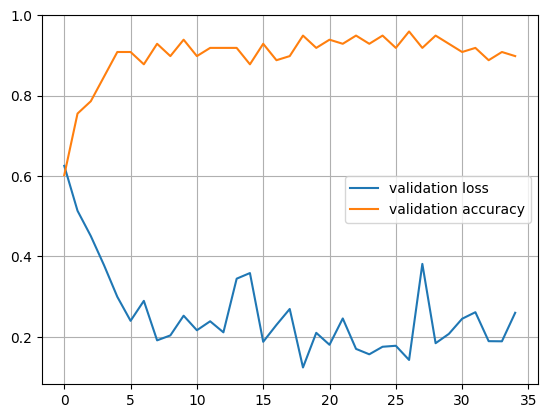

In [20]:
## stats on validation data
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

2/2 [==============================] - 10s 3s/step


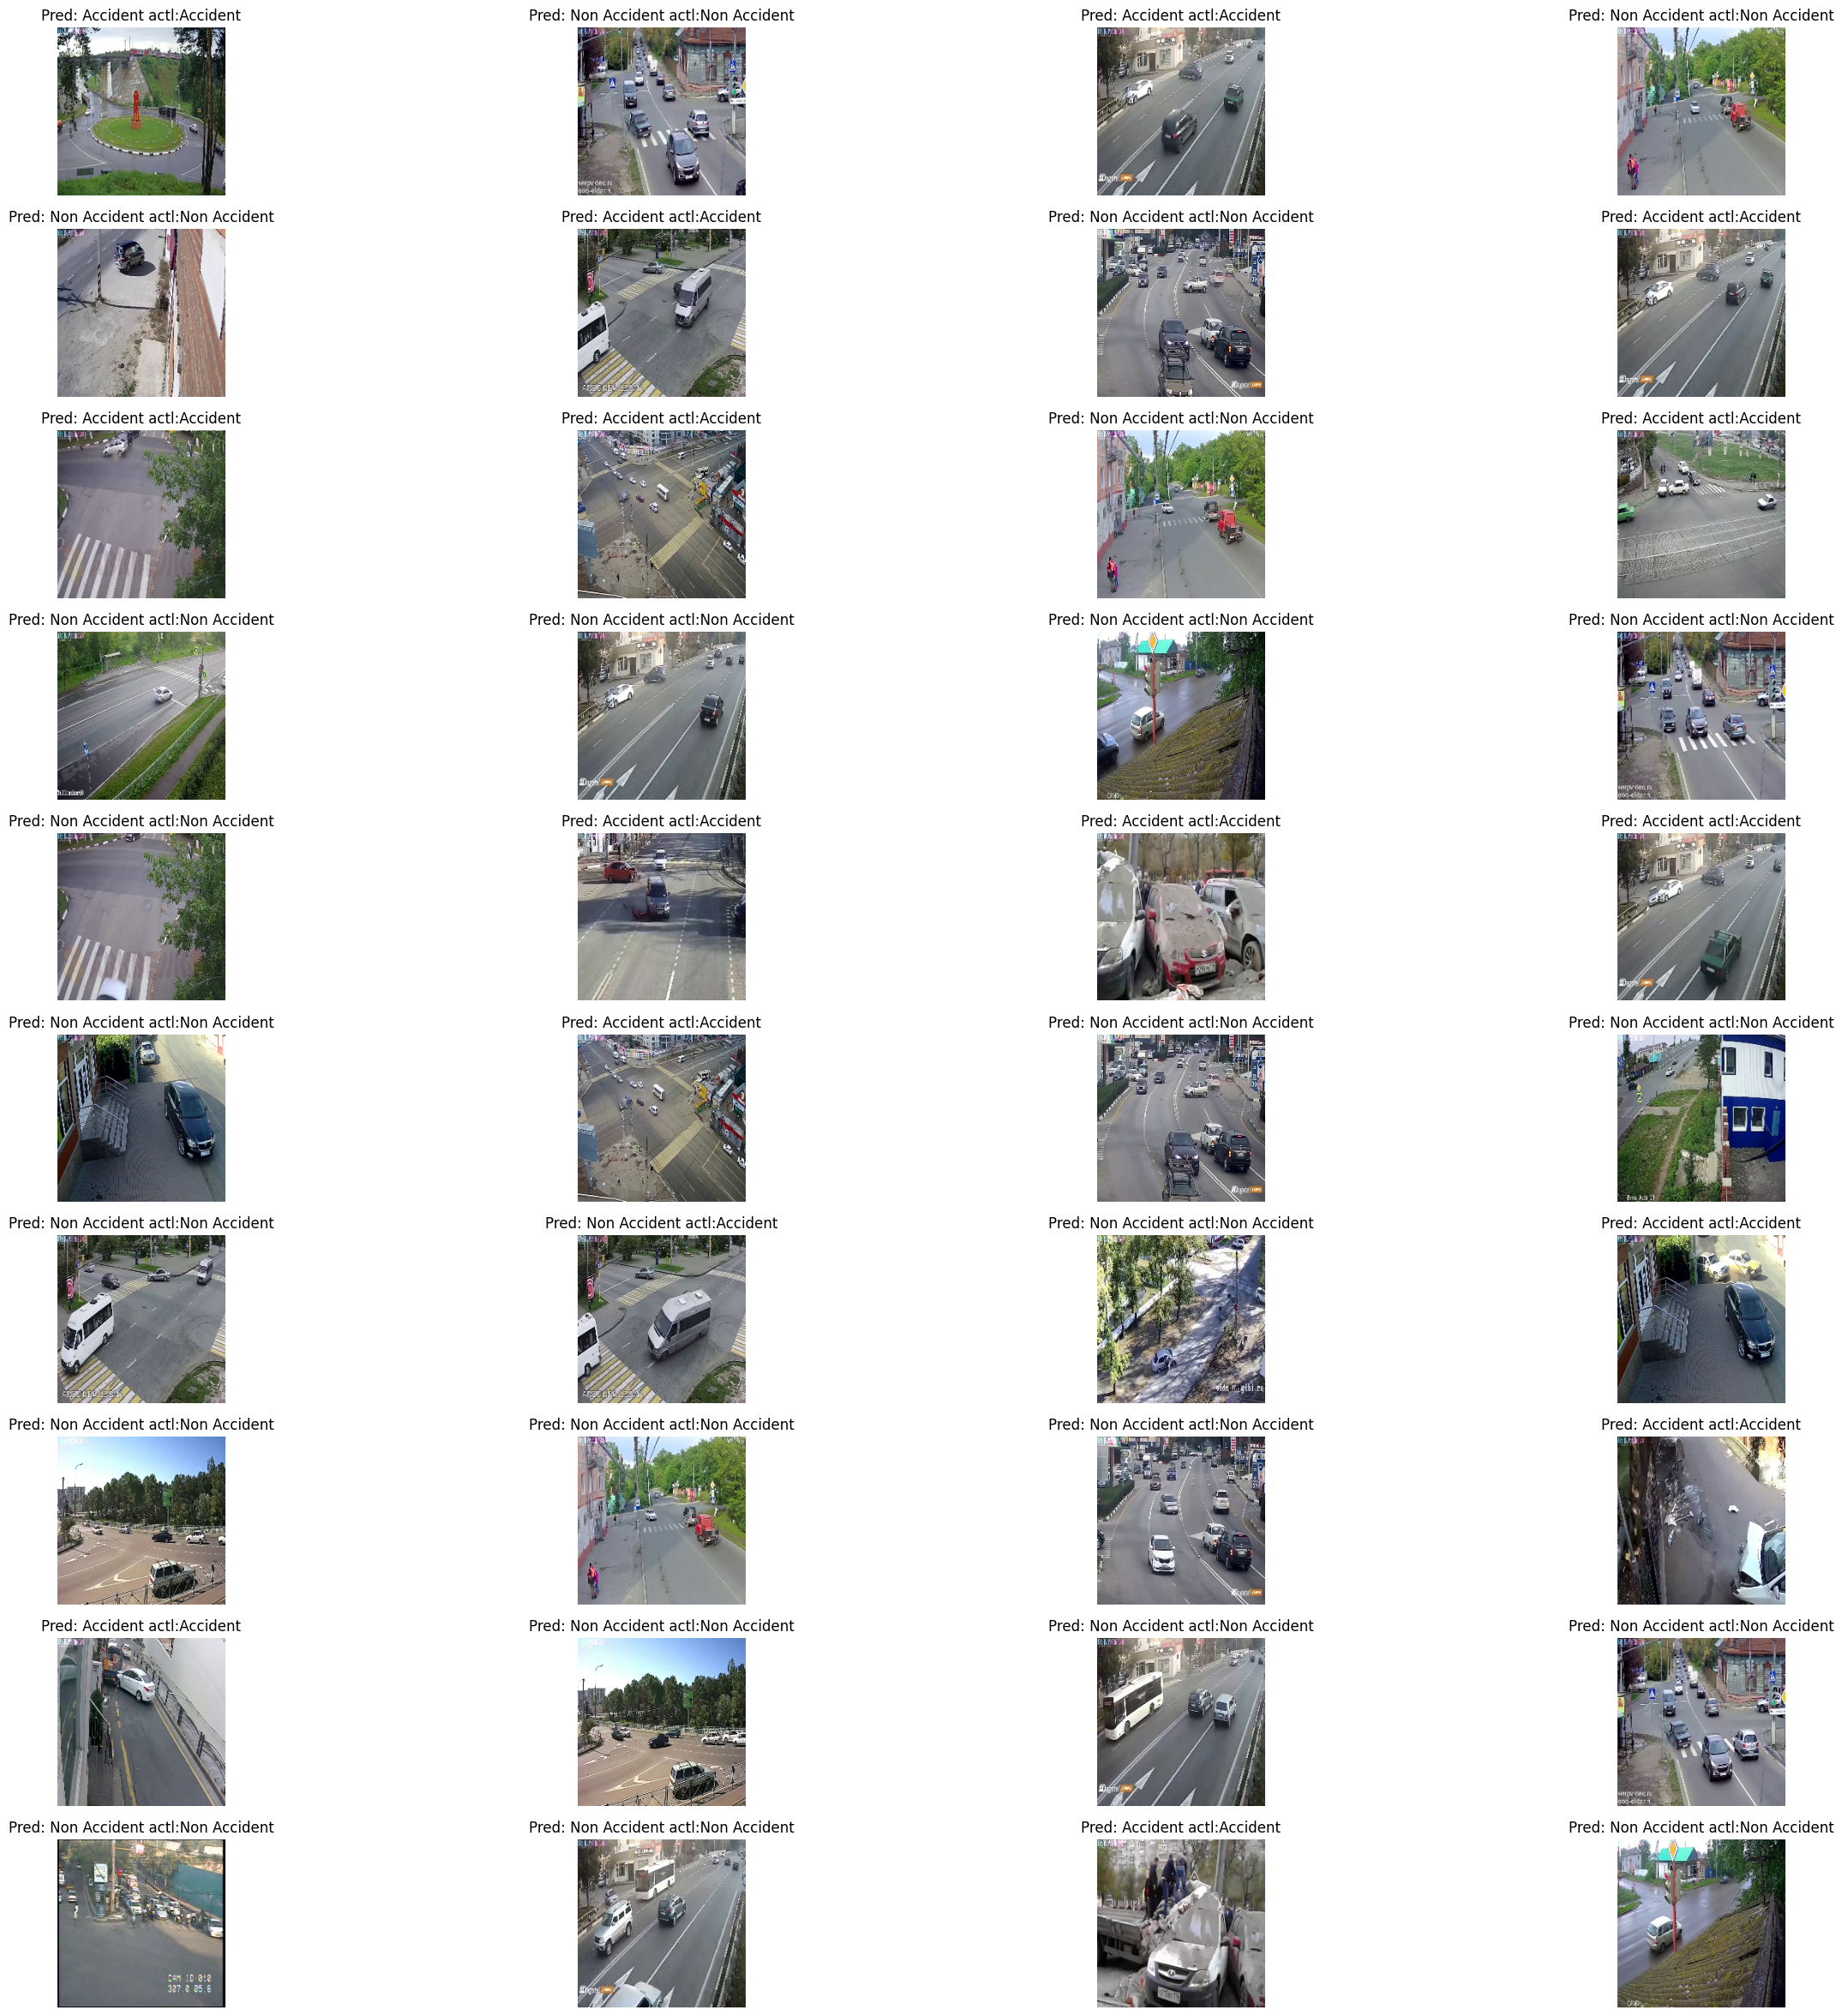

In [21]:
## lets vizualize results on testing data
AccuracyVector = []
plt.figure(figsize=(30, 30))
for images, labels in testing_data.take(1):
    predictions = model.predict(images)
    predlabel = []
    prdlbl = []

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))

    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

In [22]:
model.evaluate(testing_data)

2/2 [==============================] - 0s 148ms/step - loss: 0.1644 - accuracy: 0.9600


[0.16444848477840424, 0.9599999785423279]